In [1]:
import numpy as np
import torch


In [2]:
with open('data/names.txt', 'r') as f:
    data = f.read().splitlines()


In [3]:
chars = sorted(set(''.join([d for d in data])))
chars = ['.'] + chars
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}

print(ctoi)
print(itoc)
X = []
block_size = 2 # Tri-gram
for word in data:
    context = [0] * block_size
    for c in word + '.':
        ix = ctoi[c]
        X.append(context + [ix])
        context = context[1:] + [ix]

print(len(X))

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
228146


## Counting the occurence and then predicting 

In [4]:
# First let's 'train' a simple 'network': Count how many times one character follows another and
# use that to sample next word to generate word. NOT using a Neural Network


counts = torch.zeros(27, 27, 27)
# print(counts.size())
# counts[0, 0, 0] represents count of '...' sequence in our training data, counts[0, 1, 0] represents count of '.a.' in our training data and so on
for val in X:
    counts[val[0], val[1], val[2]] += 1


print(counts[0, 0, :])
# Now Normalize
# '...', '..a', '..b', '..c', '..d', ..... and so on should sum to 1.0 (i.e., normalize across count[0, 0, i])
# '.a.', '.aa', '.ab', '.ac', '.ad', ... and so on should sum to 1.0 (i.e., across count[0, 1, i])
# '.b.', '.ba', '.bb', '.bc', '.bd', ... and so on should sum to 1.0 (i.e., across count[0, 2, i])
# ...
# 'z..', 'z.a', 'z.b', 'z.c', 'z.d', ...
# ...
# 'zz.', 'zza', 'zzb', 'zzc', 'zzd', ...

# i.e., for every previous occurrences, we have to sum along dimension = 2 (position of i above)

counts = counts + 1 # Avoid division by zero (smoothing) as this 1 increase to higher number, we get uniform distribution. Hence smoothing.
counts = counts / counts.sum(dim=2, keepdim=True)

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])


In [5]:
# Check if it sums to 1.0
print(sum(counts[0, 0, :]))
print(sum(counts[0, 1, :]))
print(sum(counts[0, 1, :]))

# Rough code to see dimension
# ten = torch.tensor([[[1,2,3],[1,2,3],[1,2,3]], [[10,20,30],[10,20,30],[10,20,30]], [[100,200,300],[100,200,300],[100,200,300]]])
# print(ten)

# print("Sum")
# ten.sum(dim=2, keepdim=True)
# dim0 = (3, 3)
# dim1 = (1, 3)
# dim2 = (3, 1)

tensor(1.0000)
tensor(1.)
tensor(1.)


In [6]:
# Now sample from that counts (PREDICTION Step)

g = torch.Generator().manual_seed(1024)
for _ in range(50):
    out = []
    ix, prev_ix = 0, 0
    while True:
        # Now sample index from count[0, 0, :] row.
        p = counts[prev_ix, ix, :]
        new_ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[new_ix])
        if new_ix == 0:
            break
        prev_ix = ix
        ix = new_ix
    print(''.join(out))


kynn.
karthordyn.
ja.
xen.
conn.
zoemadiah.
lanunne.
alen.
zeh.
saia.
jayton.
ta.
getsmya.
ja.
azdey.
ah.
adasenicelyntjrthad.
estorraleagra.
brafines.
johila.
nehori.
nessmdkken.
hanobdincina.
kyanaslggxyanaizlyn.
non.
stytosper.
haleikashada.
aizliand.
olce.
aravori.
arie.
tygtvin.
foko.
ne.
dalyn.
ronni.
suha.
keightya.
mar.
ri.
hen.
jell.
bree.
yunikyrein.
yic.
mirrhyrivikazenton.
lesynn.
el.
muna.
otanew.


In [ ]:
# Evaluate the quality of this model:

# For that we look at the probability of the dataset from our 'learned' counts model.
for x in X[:10]:
    print(''.join(itoc[i] for i in x), end='--> ')
    print(f'{counts[x[0], x[1], x[2]].item():.2f}')

# MLE says that a good model maximizes the product of likelihood of this data
# since product of probabilities would be very small, we're taking log probability

print("Quality of the model: summarized by negative log likelihood")
log_likelihood = 0.0
n = 0
for x in X:
    prob = counts[x[0], x[1], x[2]]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1

# Log likelihood = 0 when PS = 1.0 (which we aim to go towards)
# Log likelihood = -ve when PS < 1.0 (which says that we haven't fitted the prediction for the likelihood.)

# We want a loss function (i.e., 0 when prediction is good, high when prediction is bad)
# so we use Negative log likelihood (nll) as loss function.
# we also average it instead of sum.
nll = -1 * log_likelihood
loss = nll/n

print(f'{loss=}')

# Right now, since we counted how many times 3rd character occurs given first two characters, our model right now is 'perfect'. So this is the loss that we can get to even when we train a neural network to do this.

..e--> 0.05
.em--> 0.19
emm--> 0.13
mma--> 0.37
ma.--> 0.07
..o--> 0.01
.ol--> 0.25
oli--> 0.11
liv--> 0.02
ivi--> 0.27
Quality of the model: summarized by negative log likelihood
loss=tensor(2.2120)


## Training a Neural Network for Trigram Character Level Language Model.

- We took an approach that we felt natural, i.e, counting the times last character appeared given two characters ahead, we computed the probabilities. We then used that distribution to predict the next character in prediction phase.
- Now, as the number of character increase, this becomes computationally infeasible.
- So, we want to use a neural network to do that.
- Here, we input two characters to the neural network and it predicts the probability distribution over the next characters.

In [8]:
# Print input data
print(X[:10])

[[0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1], [13, 1, 0], [0, 0, 15], [0, 15, 12], [15, 12, 9], [12, 9, 22], [9, 22, 9]]


In [ ]:
x = []
y = []
for data in X[:5]:
    x.append([data[0], data[1]])
    y.append(data[2])

x = torch.tensor(x)
y = torch.tensor(y)


torch.Size([4, 2]) torch.Size([4])
torch.Size([0, 2]) torch.Size([0])
torch.Size([1, 2]) torch.Size([1])


In [160]:
# Since we can't pass int64 (long) into a neural network, we use one hot vector
import torch.nn.functional as F

torch.manual_seed(1024)

x_enc = F.one_hot(x, num_classes=len(chars)).float()
print(x_enc.shape)
# Reshape it to stack the inputs
# X_temp = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[10, 20, 30], [40, 50, 60]]]).float()

# print(X_temp.view(len(X_temp), -1))
# print(X_temp.reshape(2, 6))

x_enc = x_enc.view(len(x_enc), -1)
print(f'{x_enc.shape=}')

# Now we make a 27 layer output to predict probability distribution over characters
# weight = 54 (inputs) * 27 (output layer)

W = torch.randn(54, 27)

out = x_enc @ W
print(f'output shape: {out.shape}')

# 1st neuron output for 1st data
neuron_output = torch.dot(x_enc[0, :], W[:, 0])
print(neuron_output)


counts = out.exp()
prob_nn = counts / counts.sum(dim=1, keepdim=True)
print(f'{prob_nn.shape=}')
print(y)
# These give the probability for the current target values (true)
print(prob_nn[0, 5], prob_nn[1, 13], prob_nn[2, 13], prob_nn[3, 1], prob_nn[4, 0])
print(prob_nn[torch.arange(len(prob_nn)), y])

# Now to compute logprob
logprob = prob_nn[torch.arange(len(prob_nn)), y].log()
print(f'{logprob=}')

# We can see that logprob of fair predictions (i.e., for 4th data -> 0.1475) is more compared to others (very less prob -> bad predictions). These are true label, so the prob should be higher.

# To compute loss, we take negative logprob (and average it)
loss = -1 * logprob.mean()
print(f'{loss=}')

# This loss is pretty high compared to what we got from counting model above. our aim is to get close to counting model loss, because that reflects true probability distribution of the dataset.

torch.Size([228146, 2, 27])
x_enc.shape=torch.Size([228146, 54])
output shape: torch.Size([228146, 27])
tensor(-2.6728)
prob_nn.shape=torch.Size([228146, 27])
tensor([ 5, 13, 13,  ..., 26, 24,  0])
tensor(0.0354) tensor(0.0087) tensor(0.0750) tensor(0.1475) tensor(0.0544)
tensor([0.0354, 0.0087, 0.0750,  ..., 0.0072, 0.0040, 0.0893])
logprob=tensor([-3.3410, -4.7408, -2.5896,  ..., -4.9295, -5.5127, -2.4155])
loss=tensor(4.1769)


In [273]:
torch.manual_seed(1024)
# Now do for all data
x = []
y = []
for data in X:
    x.append([data[0], data[1]])
    y.append(data[2])

x = torch.tensor(x)
y = torch.tensor(y)

# divide into train, validation and test sets
n1 = int(0.8 * len(x))
n2 = int(0.9 * len(x))
x_train, x_val, x_test = x[:n1], x[n1:n2], x[n2:]
y_train, y_val, y_test = y[:n1], y[n1:n2], y[n2:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# Create a random embedding
n_embed = 10
C = torch.randn((len(chars), n_embed), requires_grad=True)
# x_enc = F.one_hot(x, num_classes=len(chars)).float()
# x_enc = x_enc.view(len(x_enc), -1)
W = torch.randn((n_embed * 2, 27), requires_grad=True)

print(f"Num training data: {len(x_enc)}")
# Now we can predict the probability distribution over the characters

torch.Size([182516, 2]) torch.Size([182516])
torch.Size([22815, 2]) torch.Size([22815])
torch.Size([22815, 2]) torch.Size([22815])
Num training data: 1


In [274]:
def forward_backward_pass(x=x_train, y=y_train):
    # 1) FORWARD PASS
    x_enc = C[x].view(len(x), -1)
    logits = x_enc @ W
    counts_nn = logits.exp()
    prob_nn = counts_nn / counts_nn.sum(dim=1, keepdim=True)
    # lines 3, and 4 is softmax
    loss = -1 * torch.log(prob_nn[torch.arange(len(prob_nn)), y]).mean()
    # Loss is negative logprobs (average)
    # Line 4, 5, 7 are simply achievable through F.cross_entropy(logits, y)
    # print(F.cross_entropy(logits, y).item()) # This is clled cross_entropy because
    print(loss.item())

    # 2) Backward Pass
    W.grad = None # Clear out gradients
    C.grad = None
    loss.backward()

    # Optimize weights
    W.data += -0.1 * W.grad # Gradients point towards the increase in loss.
    C.data += -0.1 * C.grad

forward_backward_pass()

11.792845726013184


In [168]:
# We train for couple of epochs
epochs = 1000
for i in range(epochs):
    print(f'Epoch {i}:', end=" ")
    forward_backward_pass()

Epoch 0: 11.288183212280273
Epoch 1: 10.857969284057617
Epoch 2: 10.494505882263184
Epoch 3: 10.173945426940918
Epoch 4: 9.882543563842773
Epoch 5: 9.617935180664062
Epoch 6: 9.381855964660645
Epoch 7: 9.174774169921875
Epoch 8: 8.992857933044434
Epoch 9: 8.829593658447266
Epoch 10: 8.679238319396973
Epoch 11: 8.538108825683594
Epoch 12: 8.404112815856934
Epoch 13: 8.276055335998535
Epoch 14: 8.153186798095703
Epoch 15: 8.034997940063477
Epoch 16: 7.9210968017578125
Epoch 17: 7.81116247177124
Epoch 18: 7.704921245574951
Epoch 19: 7.602131366729736
Epoch 20: 7.502580642700195
Epoch 21: 7.40608024597168
Epoch 22: 7.312459468841553
Epoch 23: 7.221569061279297
Epoch 24: 7.133275985717773
Epoch 25: 7.047460079193115
Epoch 26: 6.96401834487915
Epoch 27: 6.882855415344238
Epoch 28: 6.803890705108643
Epoch 29: 6.727049827575684
Epoch 30: 6.652266979217529
Epoch 31: 6.579482078552246
Epoch 32: 6.508641242980957
Epoch 33: 6.439695835113525
Epoch 34: 6.372598648071289
Epoch 35: 6.307308673858643


In [169]:
# Prediction
generator = torch.Generator().manual_seed(1024)
for _ in range(10):
    input_x = torch.tensor([0, 0])
    ix = 0
    output = []
    input_x = torch.cat([input_x[1:],torch.tensor([ix])])
    while True:
        x_enc = C[input_x].view(1, -1)
        logits_pred = x_enc @ W
        counts_pred = logits_pred.exp()
        probs_pred = counts_pred/counts_pred.sum(dim=1, keepdim=True)
        ix = torch.multinomial(probs_pred, num_samples=1, replacement=True, generator=generator).item()
        char = itoc[ix]
        output.append(char)
        if ix == 0:
            break
    print(''.join(output))

kjdhdkmajhmrdymsjk.
hpnhclenrznekhdamhyljnpnnhkalrtkzbhaskgajjadtdmlta.
gatbmmmejv.
azdetrcohadasenjcjakmtjrtcbalescnhrambagrbkbrtfyacazjbjflaanehojm.
vessmdkkvpbhajobdkjcmnjfkyamaslggtyanaizlfaknoersrytmskcmm.
mleckcsmadajaizcjkldboecnknasvdazharhectygtvglyfhkoanjbdtlgtbrckndasubmzkatkjtyaamjkmrtaheaejelm.
bdthjyhdmkyreimbykcnmcrrhmmavikaznmtdjcljbrlc.
eaumrnaaotanew.
aafrnkulllbv.
ksjzvkkttnajkjnrmaekidmadddcludssdlacckrjsmmmnjtknagttkharrymjkdthakscdazglrgujvtonjasbldvktmslhj.


Horrible performance.
# Now we will make a slightly deeper model and see how that performs
For that, we have to organize how we define a model

In [275]:
# Here, we make a linear neuron so that scaling up is easier.
# This initializes weights and bias and the output is similar of linear layer.
import matplotlib.pyplot as plt

BATCH_SIZE = 32

class Embedding():
    def __init__(self, vocab_size, n_embed):
        self.C = torch.randn((vocab_size, n_embed)) # Embedding matrix

    def __call__(self, x):
        return self.C[x]

    def parameters(self):
        return [self.C]


class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn(fan_in, fan_out)  *  5/3 / fan_in**0.5 # Kaiming init
        self.b = torch.randn(1, fan_out) * 0.01 # Multiply with a small number
        self.bias = bias

    def __call__(self, X):

        self.out = X @ self.W
        if self.bias is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.bias else [])

class BatchNorm():
    def __init__(self, n_hidden, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.eps = eps
        self.training = True

        self.bngain = torch.ones(1, n_hidden)
        self.bnbias = torch.zeros(1, n_hidden)
        self.bnmean_running = torch.zeros(1, n_hidden)
        self.bnstd_running = torch.ones(1, n_hidden)

    def __call__(self, logits):
        if self.training:
            mean = logits.mean(dim=0, keepdim=True)
            std = logits.std(dim=0, keepdim=True)
        else:
            mean = self.bnmean_running
            std = self.bnstd_running
        xhat = (logits - mean) / (std + self.eps)
        self.out = self.bngain * xhat + self.bnbias
        if self.training:
            with torch.no_grad():
                self.bnmean_running = (1 - self.momentum) * self.bnmean_running + self.momentum * mean
                self.bnstd_running = (1 - self.momentum) * self.bnstd_running + self.momentum * std
        return self.out

    def parameters(self):
        return [self.bngain, self.bnbias]


class Tanh(object):
    def __call__(self, input):
        self.out = torch.tanh(input)
        return self.out

    def parameters(self):
        return []

def train(X, y, layers, parameters, epochs, C, lr=0.1, verbose=False):
    all_loss = []
    for epoch in range(epochs):
        # lets take a mini batch of input to do sgd so that it trains fast
        ix = torch.randint(0, X.shape[0], (BATCH_SIZE, ))
        X_batch = X[ix]
        logits = C(X_batch).view(BATCH_SIZE, -1)
        # logits = C(X).view(len(X), -1)
        # Forward pass
        for i, layer in enumerate(layers):
            logits = layer(logits)
        # Since taking exp of logits, and then dividing it by sum is softmax, we're just going to take softmax
        # you can directly compute loss with F.cross_entropy(), that does softmax inside of it
        # loss = F.cross_entropy(logits, y)
        loss = F.cross_entropy(logits, y[ix])

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph

        all_loss.append(loss.log10().item())
        # make sure you flush all the gradients
        for p in parameters:
            p.grad = None
        # Do backward propagation
        loss.backward()
        # optimize
        for p in parameters:
            p.data += -lr * p.grad
        if verbose:
            print(f'Epoch: {epoch}, loss: {loss.item()}')
    return all_loss


In [226]:
a = torch.Tensor([[1,2,3],
                  [3,4,5],
                  [6,7,8]])
print(a.shape)
mean_a_dim_0 = a.mean(dim=0, keepdim=True)
print(mean_a_dim_0)

torch.Size([3, 3])
tensor([[3.3333, 4.3333, 5.3333]])


In [227]:
layer = Linear(n_embed * block_size, 27)
out = layer(x_enc)
print(out.shape)

torch.Size([1, 27])


### Now, we can do the same above steps with a slightly deeper model

Total parameters =  15197
Average 10 loss: 0.38


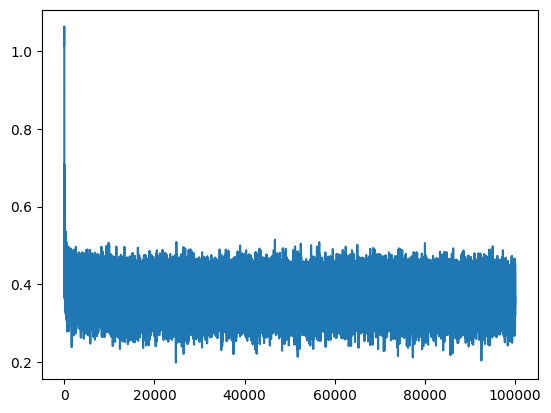

In [228]:
n_embed = 10
vocab_size = len(chars)
C = Embedding(vocab_size=vocab_size, n_embed=n_embed)
layers = [
    Linear(n_embed * block_size, 100),
    Linear(100, 100),
    Linear(100, vocab_size)
]
parameters = C.parameters() + [p for layer in layers for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters))

# lets make sure that the use grad is true for all parameters.
for p in parameters:
    p.requires_grad_(True)

all_loss = train(x_train, y_train, layers, parameters, 100000, C, lr=0.10)
print(f'Average 10 loss: {sum(all_loss[-10:])/10:.2f}')
plt.plot(all_loss)

#### Didn't improve performance because no matter how much linear layer you stack (wx + b), you can make a single linear layer that is equivalent to the stacked layers.

## Let's add non-linear layer

Total parameters =  15197
Average last 10 loss: 0.36


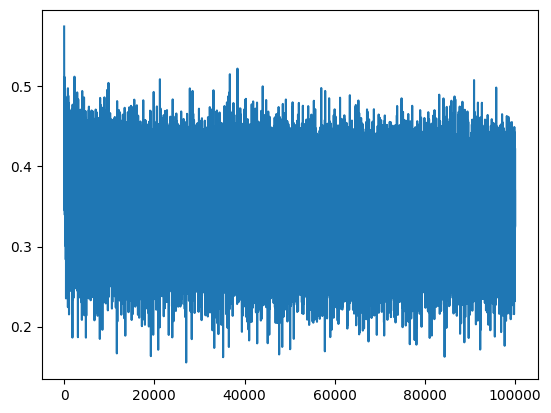

In [200]:
# Now lets add a non-linear layer (lets do tanh)
C = Embedding(vocab_size=vocab_size, n_embed=n_embed)
layers_w_nl = [
    Linear(n_embed * block_size, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 27)
]
parameters_nl = C.parameters() + [p for layer in layers_w_nl for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters))

# lets make sure that the use grad is true for all parameters.
for p in parameters_nl:
    p.requires_grad_(True)

# Now train like before
all_loss = train(x_train, y_train, layers_w_nl, parameters_nl, 100000, C, lr=0.1)
print(f'Average last 10 loss: {sum(all_loss[-10:])/10:.2f}')
plt.plot(all_loss)

## Not a good performance, the loss is very high in the beginning (remember loss plot is in log scale).
#### Lets scale the loss down at the initialization (scale down W and b), and increase the number of layers

Total parameters =  44997
Average last 10 loss: 0.35


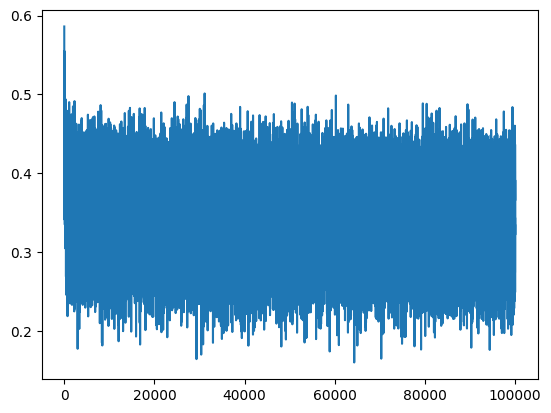

In [208]:
C = Embedding(vocab_size=vocab_size, n_embed=n_embed)
layers_w_nl = [
    Linear(n_embed * block_size, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 100, bias=False), Tanh(),
    Linear(100, 27)
]
parameters_nl = C.parameters() + [p for layer in layers_w_nl for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters_nl))

# lets make sure that the use grad is true for all parameters.
for p in parameters_nl:
    p.requires_grad = True

# Now train like before
all_loss = train(x_train, y_train, layers_w_nl, parameters_nl, 100000, C, lr=0.10, verbose=False)
print(f'Average last 10 loss: {sum(all_loss[-10:])/10:.2f}')
plt.plot(all_loss)

## Log loss summary:
Just linear layer: Average 10 loss: 2.60 

Added non-linear layer: Average last 10 loss: 1.23 

Scaled initialization weights, for good initialization: Average last 10 loss: 0.52

### Nope. Didn't work.
1) Let's see visually how our network is performing.
2) Let's split train and validation set.
3) train on the training set, and eval loss on the validation set.

layer: 1 ->  Tanh: mean -0.02, std +0.80, saturated: 30.41
layer: 3 ->  Tanh: mean +0.04, std +0.85, saturated: 34.56
layer: 5 ->  Tanh: mean -0.01, std +0.89, saturated: 42.84
layer: 7 ->  Tanh: mean +0.06, std +0.92, saturated: 50.13
layer: 9 ->  Tanh: mean -0.02, std +0.78, saturated: 27.69


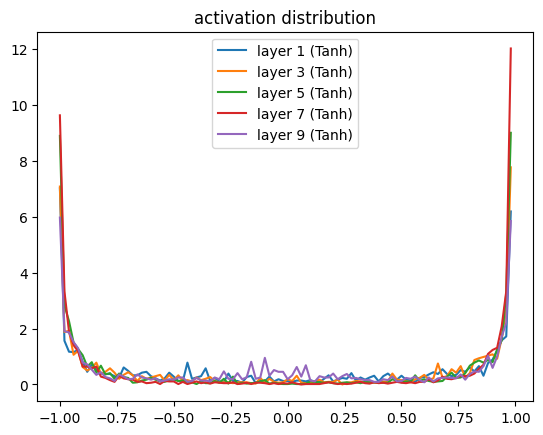

In [210]:
# Visualize the histogram of activation
def plot_tanh_activation(layers):
    plt.figure()
    legends = []
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            t = layer.out
            print("layer: %d -> %5s: mean %+.2f, std %+.2f, saturated: %.2f" % (i, layer.__class__.__name__, t.mean().item(), t.std().item(), (t.abs() > 0.97).float().mean() * 100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('activation distribution')
plot_tanh_activation(layers_w_nl)

# looks very saturated (most of the neurons are not active)

Text(0.5, 1.0, 'Activation of layer 7')

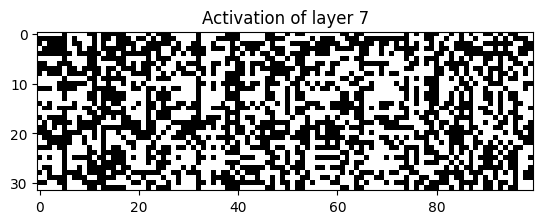

In [212]:
plt.figure()
plt.imshow(layers_w_nl[7].out.abs() > 0.97, cmap='gray')
plt.title("Activation of layer 7")
# There are a lot of white, i.e., those neurons are not active.

layer: 1 ->  Tanh: mean -1.318974e-05, std +8.034952e-04
layer: 3 ->  Tanh: mean +1.132903e-05, std +8.262750e-04
layer: 5 ->  Tanh: mean -5.559088e-06, std +1.140946e-03
layer: 7 ->  Tanh: mean +3.989343e-06, std +2.245478e-03
layer: 9 ->  Tanh: mean +4.480631e-05, std +4.289123e-03


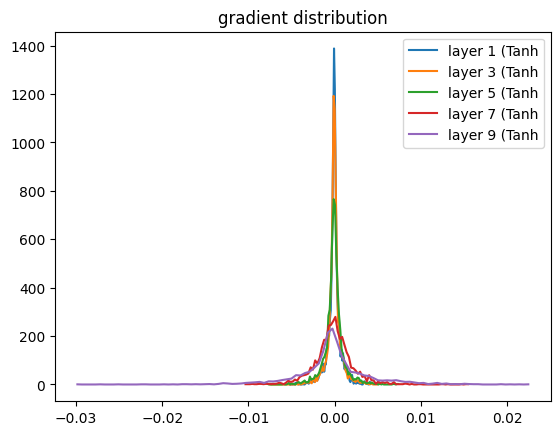

In [215]:
# Visualize the histogram of gradient
def plot_layer_gradient(layers):
    plt.figure()
    legends = []
    for i, layer in enumerate(layers):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            print("layer: %d -> %5s: mean %+e, std %+e" % (i, layer.__class__.__name__, t.mean().item(), t.std().item()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends)
    plt.title('gradient distribution')

plot_layer_gradient(layers_w_nl)
# Gradient looks flattened as the layer increases (not a good sign)

# Precise weight tuning is hectic, normalization should be done

We want hidden layer activations to be centered around 0 and have a standard deviation of 1, because the gradient is more stable.  Input to Tanh should not be 1 or -1 (i.e., derivative = 0 and the gradient wont flow). 

So we want to standardize the pre-activation outputs of each layer. 
We do Batch Normalization for this.

Total parameters =  46051
Average last 10 loss: 0.34


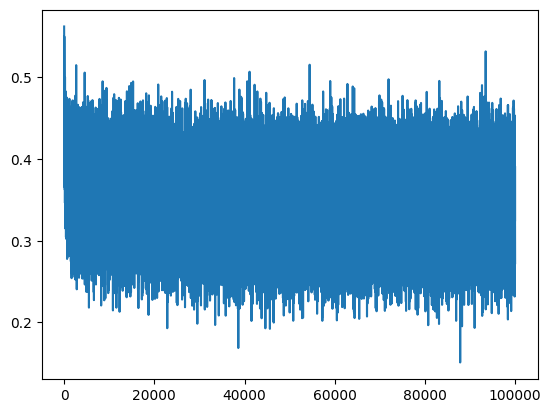

In [276]:
C = Embedding(vocab_size=vocab_size, n_embed=n_embed)
layers_w_nl_w_bn = [
    Linear(n_embed * block_size, 100, bias=False), BatchNorm(100), Tanh(),
    Linear(100, 100, bias=False), BatchNorm(100), Tanh(),
    Linear(100, 100, bias=False), BatchNorm(100), Tanh(),
    Linear(100, 100, bias=False), BatchNorm(100), Tanh(),
    Linear(100, 100, bias=False), BatchNorm(100), Tanh(),
    Linear(100, vocab_size), BatchNorm(vocab_size)
]
parameters_nl = C.parameters() + [p for layer in layers_w_nl_w_bn for p in layer.parameters()]
print("Total parameters = ", sum(p.nelement() for p in parameters_nl))

# lets make sure that the use grad is true for all parameters.
for p in parameters_nl:
    p.requires_grad = True

# Now train like before
all_loss = train(x_train, y_train, layers_w_nl_w_bn, parameters_nl, 100000, C, lr=0.10, verbose=False)
print(f'Average last 10 loss: {sum(all_loss[-10:])/10:.2f}')
plt.plot(all_loss)

layer: 2 ->  Tanh: mean -0.00, std +0.68, saturated: 8.34
layer: 5 ->  Tanh: mean +0.01, std +0.71, saturated: 10.06
layer: 8 ->  Tanh: mean -0.00, std +0.73, saturated: 12.44
layer: 11 ->  Tanh: mean +0.03, std +0.75, saturated: 11.94
layer: 14 ->  Tanh: mean +0.02, std +0.77, saturated: 13.84


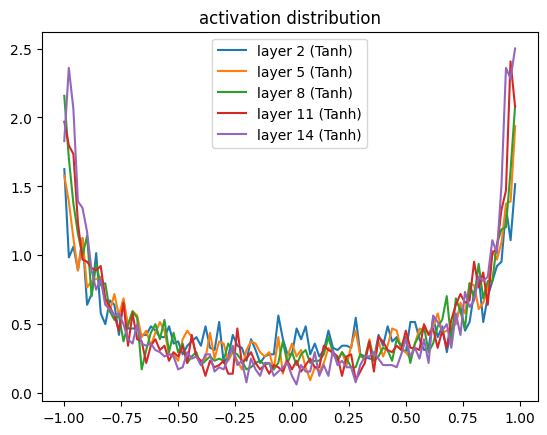

In [277]:
plot_tanh_activation(layers_w_nl_w_bn)

layer: 2 ->  Tanh: mean -1.396984e-11, std +2.298034e-03
layer: 5 ->  Tanh: mean -8.585630e-12, std +2.368402e-03
layer: 8 ->  Tanh: mean -5.529728e-12, std +2.306634e-03
layer: 11 ->  Tanh: mean -2.910383e-13, std +2.280388e-03
layer: 14 ->  Tanh: mean +8.549250e-12, std +2.425904e-03


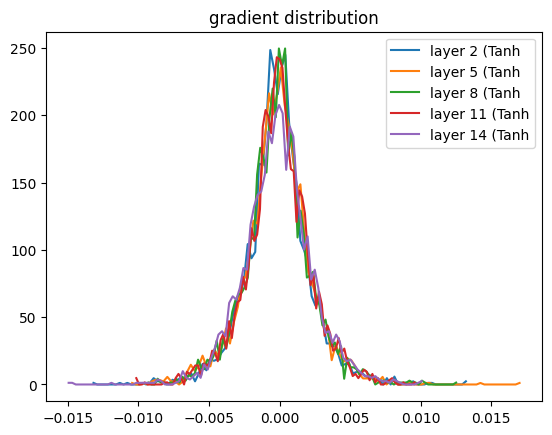

In [278]:
plot_layer_gradient(layers_w_nl_w_bn)

In [280]:
generator = torch.Generator().manual_seed(1024)
@torch.no_grad()
def predict(layers, examples=10):
    for layer in layers:
        layer.training = False
    context = [0] * block_size
    for _ in range(examples):
        emb = C(torch.tensor([context]))
        x_input = emb.view(1, -1)
        print(x_input)
        while True:
            for layer in layers:
                x_input = layer(x_input)
            print(x_input)
            probs = torch.softmax(x_input, dim=1)
            print(probs)
            ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=generator).item()
            context = context[1:] + [ix]
            output.append(ix)
            if ix == 0:
                break
        print(''.join(itoc[i] for i in output))

In [ ]:

# print(layers_w_nl_w_bn[1].bnmean_running)
# print(layers_w_nl_w_bn[1].bnstd_running)
# with torch.no_grad():
#     for layer in layers_w_nl_w_bn:
#         layer.training = False
# context = [0] * block_size
# emb = C(torch.tensor([context]))
# print(emb.view(1, -1).shape)
#     x_input = emb.view(1, -1)
#     x_input = layers_w_nl_w_bn[0](x_input)
#     print(layers_w_nl_w_bn[1].bnmean_running)
#     print(layers_w_nl_w_bn[1].bnstd_running)
#     x_input = layers_w_nl_w_bn[1](x_input)
    # x_input = layers_w_nl_w_bn[2](x_input)
    # print(x_input)
predict(layers_w_nl_w_bn, 5)

torch.Size([1, 20])
tensor([[-1.2359, -0.1292, -0.0695, -1.5853,  0.7280,  0.4975,  1.3166, -0.9157,
          0.0137, -0.5308, -1.2359, -0.1292, -0.0695, -1.5853,  0.7280,  0.4975,
          1.3166, -0.9157,  0.0137, -0.5308]])
tensor([[-2.1767,  2.3739,  1.1780,  1.1280,  1.4247,  1.3200, -0.1823,  0.2293,
          0.5958,  0.1326,  1.7630,  2.2807,  1.3656,  1.6936,  1.2391, -0.0991,
          0.2592, -1.5757,  1.5417,  1.8251,  0.9759, -2.0427, -0.1764, -0.4771,
         -0.9946,  0.0678,  0.9914]])
tensor([[0.0014, 0.1339, 0.0405, 0.0385, 0.0518, 0.0467, 0.0104, 0.0157, 0.0226,
         0.0142, 0.0727, 0.1220, 0.0488, 0.0678, 0.0430, 0.0113, 0.0162, 0.0026,
         0.0582, 0.0773, 0.0331, 0.0016, 0.0104, 0.0077, 0.0046, 0.0133, 0.0336]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x27 and 20x100)

In [255]:
C